In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
import seaborn as sns
sns.set(style="white")
import time
#import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")

In [3]:
con_fname = 'y_trained/cont_KNN_5_29.02.26.txt'
cat_fname = 'y_trained/cat_RF_1_29.02.26.txt'
y_fname = 'data/train.csv'
y_con = pd.read_csv(con_fname, sep=';')['VARIABLE_CIBLE'].values
y_cat = pd.read_csv(cat_fname, sep=';')['VARIABLE_CIBLE'].values
y = pd.read_csv(y_fname, sep=';')['VARIABLE_CIBLE'].values == 'GRANTED'
n_samples = len(y)
scale(y_con, copy=False);
scale(y_cat, copy=False);

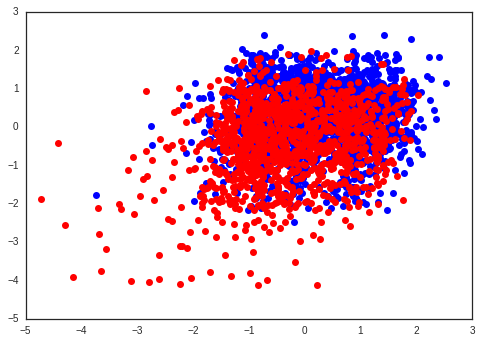

In [4]:
n_show = 3000
granted_x = []
granted_y = []
not_granted_x = []
not_granted_y = []
for i in range(n_show):
    if(y[i]):
        granted_x.append(y_con[i])
        granted_y.append(y_cat[i])
    else:
        not_granted_x.append(y_con[i])
        not_granted_y.append(y_cat[i])

plt.plot(granted_x,granted_y,'bo')
plt.plot(not_granted_x,not_granted_y,'ro')

In [5]:
y_con.shape = (n_samples,1)
y_cat.shape = (n_samples,1)
X = np.concatenate((y_con,y_cat), axis=1)

## Régression logistique polynomiale : 0.692657510534

In [6]:
n_threads = 4
deg = 2
n_taken = 150000
params = {'C':[0.00000001]}
def scorer(estimator, X, y):
    return roc_auc_score(y, estimator.predict_proba(X)[:,1])
poly = PolynomialFeatures(degree=deg, include_bias=False)
X_poly = poly.fit_transform(X)
clf = GridSearchCV(LogisticRegression(), params, scorer, n_jobs=n_threads)
start = time.time()
clf.fit(X_poly[0:n_taken],y[0:n_taken])
print("{} secondes".format(time.time() - start))
print("Score réaliste sur le train : {}".format(clf.best_score_))
print("Score sur la validation : {}".format(roc_auc_score(y[n_taken:], clf.predict_proba(X_poly[n_taken:])[:,1])))
print(clf.best_params_)

0.6253421306610107 secondes
Score réaliste sur le train : 0.7268627462650267
Score sur la validation : 0.7283882654693253
{'C': 1e-08}


In [7]:
print(y[n_taken:])
print(clf.predict_proba(X_poly[n_taken:])[:,1])
print(clf.best_estimator_.coef_)
print(clf.best_estimator_.intercept_)

[ True  True  True ...,  True  True  True]
[ 0.50001176  0.50003828  0.49993359 ...,  0.50003227  0.50002306
  0.49987615]
[[  2.09840161e-04   2.62270522e-04   6.46185313e-05  -6.70271160e-05
   -2.85738701e-05]]
[ 0.00012591]


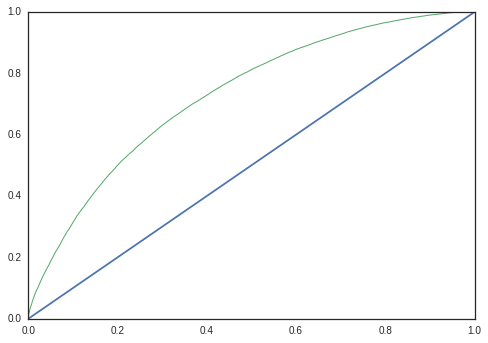

In [8]:
fpr, tpr, thresholds = roc_curve(y[n_taken:],clf.predict_proba(X_poly[n_taken:])[:,1])
plt.plot([0,1],[0,1])
plt.plot(fpr, tpr, lw=1)

In [9]:
# 0.733542520598
# 0.734036237988 avec degré = 4 et C = 0.5. Sub à 0.692657510534.Qu'est-ce qui peut bien overfit autant ?
# Un validation set donne des scores similaires mais les soumissions ne sont pas à la hauteur... Problème en amont ?
# 0.691966530694 soumission à 0.691966530694 en ayant tout vérifié... Incompréhensible. Il y a forcément un problème 
# avec les fichiers de soumissions à combiner.

# On a compris l'overfit : les deux modèles sous-jacents ont été train sur toutes les données, ce qui a une influence
# même si on ne train le modèle final qu'avec une partie.

In [10]:
#[[ 0.48636414  0.71867463]]
#[ 0.38319657]

#[[ 0.48576174  0.72159832 -0.01637573 -0.055081    0.0333886 ]]
#[ 0.37644602]

# Modèle presque identique avec les features polynomiales en plus... Et ce même avec un grand C.

[(-6, 6),
 (-6, 6),
 None]

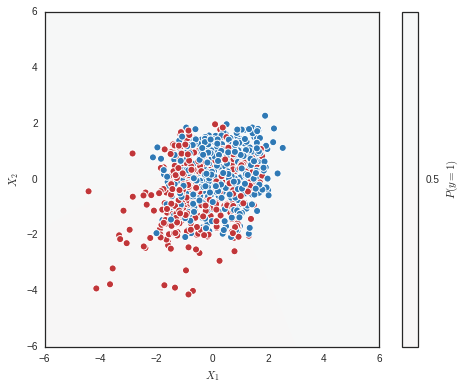

In [11]:
n_show = 1000
xx, yy = np.mgrid[-6:6:.01, -6:6:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(poly.fit_transform(grid))[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[:n_show,0], X[:n_show, 1], c=y[:n_show], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-6, 6), ylim=(-6, 6),
       xlabel="$X_1$", ylabel="$X_2$")

In [12]:
con_fname = 'subs/continue_KNN5.txt'
cat_fname = 'subs/cate_RF_1.txt'
y_con_sub = np.loadtxt(con_fname)
y_cat_sub = np.loadtxt(cat_fname)
n = y_con_sub.shape[0]
y_con_sub.shape = (n,1)
y_cat_sub.shape = (n,1)
scale(y_con_sub, copy=False);
scale(y_cat_sub, copy=False);
print(y_con_sub)

[[-1.4781629 ]
 [ 0.25553433]
 [ 0.90683646]
 ..., 
 [ 0.01131039]
 [ 0.86392872]
 [-0.85685716]]


In [14]:
X_sub = np.concatenate((y_con_sub,y_cat_sub), axis=1)
X_sub_poly = poly.fit_transform(X_sub)
print(clf.predict_proba(X_sub_poly)[:,1])
np.savetxt('subs/recollement2.txt',clf.predict_proba(X_sub_poly)[:,1])

[ 0.49957393  0.50002814  0.50012944 ...,  0.49994478  0.50004897
  0.5000793 ]


[(-6, 6),
 (-6, 6),
 None]

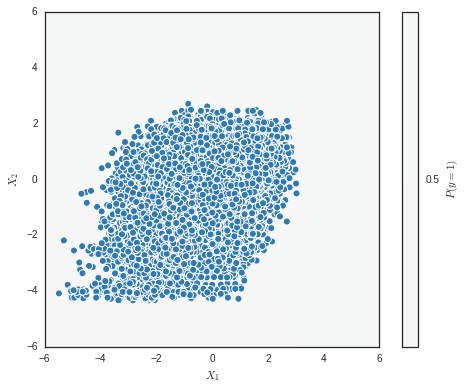

In [15]:
y_sub_false = np.ones(X_sub.shape[0]) == 1
n_show = X_sub.shape[0]
xx, yy = np.mgrid[-6:6:.01, -6:6:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(poly.fit_transform(grid))[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_sub[:n_show,0], X_sub[:n_show, 1], c=y_sub_false[:n_show], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-6, 6), ylim=(-6, 6),
       xlabel="$X_1$", ylabel="$X_2$")

In [ ]:
X_train, X_valid, y_train, y_valid = 
    train_test_split(X, y, test_size=0.2)
    
clf = RandomForestClassifier(
        n_estimators=5000, max_leaf_nodes=36000,
        oob_score=False, min_samples_leaf=1,
        min_samples_split=1, n_jobs=-1)

clf.fit(X_train,y_train)

y_pred_valid = clf.predict_proba(X_valid)[:, 1]
print(roc_auc_score(y_valid,y_pred_valid))